## Setup - install packages and restart kernel to begin

In [1]:
# !pip install  absl-py scann tensorflow-datasets google-cloud-bigquery tensorflow-recommenders google-cloud-aiplatform tensorflow-io --user

     |████████████████████████████████| 10.6 MB 4.5 MB/s            
     |████████████████████████████████| 85 kB 6.1 MB/s             
     |██████████████████████████████▊ | 469.2 MB 66.4 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 489.6 MB 10 kB/s              
     |████████████████████████████████| 2.1 MB 65.4 MB/s            
     |████████████████████████████████| 23.1 MB 23.1 MB/s            
     |████████████████████████████████| 2.1 MB 32.7 MB/s            
     |████████████████████████████████| 13.4 MB 47.6 MB/s            
     |████████████████████████████████| 1.3 MB 44.1 MB/s            
     |████████████████████████████████| 463 kB 87.8 MB/s            
     |████████████████████████████████| 129 kB 48.0 MB/s            
     |████████████████████████████████| 152 kB 91.2 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 

# Two-Tower Recommendation Example

This notebook is intended to show an end-end example of training a two-tower recommendation model using [Tensorflow Recommenders](https://www.tensorflow.org/recommenders). 

The intended use is to provide a working example of the TFRS library and show how training can produce custom embeddings and models for use with the matching engine. For more info on matching engine, see the `bqml-scann` folder for an end-end example

This mostly follows the example of a deep retreival model as found on [this page](https://www.tensorflow.org/recommenders/examples/deep_recommenders) 

The steps are as follows

1. Import libraries and set variables
2. Pull data from the `css-retail` example, from the query that creates the training data (see commented BQ SQL)
3. Define the two tower's classes - product class for the first model, event class for the second. Event is equivalent to user-query events with a resulting puchase
  * Note that the user class is a subclass of event and used to model embeddings at the user level
4. Develop the two-tower class and set training objectives using the tfrs tasks (retreival task) to compute loss
5. Train the model, establish a Tensorboard to assess performance
6. Save the model for use in matching engine (or embeddings)


## Import libs

In [2]:
import os
import time
import json

from absl import app
from absl import flags
from absl import logging


import tensorflow_recommenders as tfrs
import numpy as np
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession
 
    
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes


import tensorflow as tf


from google.cloud import aiplatform as vertex_ai
from google.cloud import bigquery
from google.cloud import storage

## Set Vars

Many of these paremeters use `ABSL` as flagging and logging will be critical if a pipeline or distributed training is used.

In [3]:
!gsutil mb -l us-central1 gs://jsw-bucket2

Creating gs://jsw-bucket2/...
ServiceException: 409 A Cloud Storage bucket named 'jsw-bucket2' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [4]:
PREFIX = 'two-tower'
#PREFIX = 'css_retail'
DISPLAY_NAME = f'{PREFIX}-tensorboard'
PROJECT= 'CHANGE_ME'
REGION='us-central1'

STAGING_BUCKET = """gs://{}_vertex_training""".format(PROJECT)

FLAGS = flags.FLAGS
LR = 0.0002 #flags.DEFINE_float("LR", 0.001, "Learning Rate")
EMBEDDING_DIM = 64 #flags.DEFINE_integer("EMBEDDING_DIM", 15, "Embedding dimension")
MAX_TOKENS = 300_000 #flags.DEFINE_integer("MAX_TOKENS", 15, "Max embeddings for query and last_n products")
NUM_EPOCHS = 100 #flags.DEFINE_integer("NUM_EPOCHS", 29, "Number of epochs")
MODEL_DIR = 'model-dirs' #flags.DEFINE_string("MODEL_DIR", 'model-dirs-', "GCS Bucket to store the model artifact")
DROPOUT = False #flags.DEFINE_bool("DROPOUT", False, "Use Dropout - T/F bool type")
DROPOUT_RATE = None #flags.DEFINE_float("DROPOUT_RATE", -1.4, "Dropout rate only works with DROPOUT=True")
#flags.DEFINE_integer("N_PRODUCTS", 19999, "number of products considered for embedding")
BATCH_SIZE = 256 #flags.DEFINE_integer("BATCH_SIZE", 1023, "batch size")
ARCH = '[1000,500,100]' #flags.DEFINE_string("ARCH", '[128,64]', "deep architecture, expressed as a list of ints in string format - will be parsed into list")
SEED = 8947 #flags.DEFINE_integer("SEED", 41781896, "random seed")
#flags.DEFINE_string("TF_RECORDS_DIR", "gs://tfrs-central-a", "source data in tfrecord format gcs location")
DATASET = 'css_retail'
PROJECT_ID = PROJECT
JOB_DIR = 'gs://jsw-bucket2/'
N_BINS = 10


# initialize vertex sdk
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)


client = bigquery.Client()

## Create the training tables in Bigquery

The SQL only needs to be run once to create the tables. Note the data is a google-internal example and meant to illustrate how to leverage BQ SQL for training custom TFRS models. The data is as follows:

1. Users train - this table is a collection of the user's demographics
2. Train - this is a creation of user event - we pull from the `users_train` table and also bring in events (purchases)
  * Additional events like user queries are recommended at this stage to collect user intent
3. Product train - this is essentially a product catalog, used for the product tower training


### Customer SQL

In [5]:
# customer_data_sql = """
# CREATE OR REPLACE TABLE `css_retail.users_train` AS
# SELECT
#     SAFE_CAST(id as STRING) AS userId,
#     SAFE_CAST(age as FLOAT64) AS age,
#     gender,
#     latitude,
#     longitude,
#     zip,
#     traffic_source,
#     SAFE_CAST(TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), created_at, DAY) AS FLOAT64) AS customer_lifetime_days
# FROM `css_retail.customers` AS customers
# """
# _ = client.query(customer_data_sql)
# _.result()

### Product SQL

In [6]:
# product_catalog_sql = """
# CREATE OR REPLACE TABLE `css_retail.product_train` AS 
# WITH inner_q AS (
#     SELECT
#         SAFE_CAST(rad.id AS STRING) as productId,
#         title,
#         description,
#         product_metadata.exact_price.original_price AS price,
#         ARRAY_TO_STRING(cats.categories, ' ') AS categories
#     FROM `css_retail.recommendation_ai_data` AS rad,
#     UNNEST(category_hierarchies) AS cats
# ) 
# 	SELECT DISTINCT
#     productId,
#     title,
#     description,
#     price,
#     categories
# FROM inner_q
# GROUP BY productId, title, description, price, categories
# """
# ################### LIMIT FOR DEV ##############
# _ = client.query(product_catalog_sql)
# _.result()

### Event SQL

In [7]:
# purchase_data_sql = """
# CREATE OR REPLACE TABLE `css_retail.train` AS
# WITH inner_q AS (
#     SELECT
#         SAFE_CAST(userInfo.userId AS STRING) AS userId,
#         SAFE_CAST(eventTime AS TIMESTAMP) AS eventTime,
#         productEventDetail.cartId,
#         productEventDetail.purchaseTransaction.revenue,
#         SAFE_CAST(products.id as string) productId,
#         products.quantity,
#         products.displayPrice AS price
#     FROM `css_retail.purchase_complete` AS purchase,
#     UNNEST(productEventDetail.productDetails) AS products
# ) SELECT
#     user.* ,
#     inner_q.* EXCEPT (eventTime, userId, cartId, price, revenue),
#     UNIX_MILLIS(eventTime) AS eventTime,
#     SAFE_CAST(EXTRACT(HOUR FROM eventTime) AS STRING) AS hour,
#     SAFE_CAST(EXTRACT(DAY FROM eventTime) AS STRING) AS day,
#     SAFE_CAST(EXTRACT(MONTH FROM eventTime) AS STRING) AS month,
#     SAFE_CAST(EXTRACT(DAYOFWEEK FROM eventTime) AS STRING) AS dow,
    
#     product.* EXCEPT (productId)
# FROM inner_q JOIN `css_retail.users_train` as user ON inner_q.userId = user.userId
# JOIN `css_retail.product_train` as product ON inner_q.productId = product.productId
# """
# _ = client.query(purchase_data_sql)
# _.result()

## Create the tensorflow.io interface for the event and product table in Bigquery

Best practices from Google are in this [blog post](https://towardsdatascience.com/how-to-read-bigquery-data-from-tensorflow-2-0-efficiently-9234b69165c8)

In [8]:

import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession


def read_dataset_prod(client, row_restriction, batch_size=1024):
    TABLE_ID = "product_train"
    COL_NAMES = ['productId', 'title', 'description', 'price', 'categories']
    COL_TYPES = [dtypes.string, dtypes.string, dtypes.string, dtypes.float64, dtypes.string]
    bqsession = client.read_session(
        "projects/" + PROJECT_ID,
        PROJECT_ID, TABLE_ID, DATASET,
        COL_NAMES, COL_TYPES,
        requested_streams=2,
        row_restriction=row_restriction)
    dataset = bqsession.parallel_read_rows()
    return dataset.prefetch(1).shuffle(batch_size*10).batch(batch_size)

def read_dataset(client, row_restriction, batch_size=1024):
    TABLE_ID = "train"
    COL_NAMES = ['userId', 'age', 'gender', 'latitude', 'longitude', 'zip', 'traffic_source',  'customer_lifetime_days',
                'productId', 'quantity', 'eventTime', 'hour', 'day', 'month', 'dow', 'title', 'description', 'price', 'categories']
    COL_TYPES = [dtypes.string, dtypes.float64, dtypes.string, dtypes.float64, dtypes.float64, dtypes.string, dtypes.string, dtypes.float64, dtypes.string, 
                 dtypes.int64, dtypes.int64, dtypes.string, dtypes.string, dtypes.string, dtypes.string, dtypes.string, dtypes.string, dtypes.float64,
                dtypes.string]
    bqsession = client.read_session(
        "projects/" + PROJECT_ID,
        PROJECT_ID, TABLE_ID, DATASET,
        COL_NAMES, COL_TYPES,
        requested_streams=2,
        row_restriction=row_restriction)
    dataset = bqsession.parallel_read_rows()
    return dataset.prefetch(1).shuffle(batch_size*10).batch(batch_size)



## Product Model Class

Here, we begin to create the custom classes for modeling used in the tfrs framework. The process generally follows

1. Design the conceptual architecuture of the two tower classes
2. Create vectorizors for high cardnaility variables
  * e.g.: Product hierarchy, product SKU/title/id
3. Set vectorizor adapts to initialize the naive embeddings
  * Be sure to parameterize the data for this step, it is a one-time pass over the data
4. Use the vectorizors to create embeddings, user 1d pooling to collect multiple embeddings and average (e.g. collapse multiple terms in search query to one pooled average embedding)
5. Add other variables (continuous and low-cardnaility categorical) and concatenate into one embedding
6. Build deep layers on top and parameterize with `layer_sizes` string


In [10]:
class ProductModel(tf.keras.Model):
    def __init__(self, layer_sizes, adapt_data):
        super().__init__() #necessary to inherit the Model class
        
        #preprocess stuff
        logging.info('Preprocessing Running - product model')
        self.sku_count = len(np.unique(
            np.concatenate(
                list(
                    adapt_data.map(lambda x: x["productId"])
                )
            )
        ))
        #categorical: sku
        self.sku_vectorizor = tf.keras.layers.TextVectorization(max_tokens=self.sku_count,  name='sku_vec', input_shape=())
        self.title_vectorizor = tf.keras.layers.TextVectorization(max_tokens=self.sku_count,  name='title_vec', ngrams=2, input_shape=())
        self.description_vectorizor = tf.keras.layers.TextVectorization(max_tokens=self.sku_count, name='desc_vec', input_shape=())
        self.category_vectorizor = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKENS, name='cat_vec', ngrams=2, input_shape=())


        logging.info('Lookups Complete - product model')

        #adapt stuff
        logging.info('Adapts Running - product model')
        self.category_vectorizor.adapt(adapt_data.map(lambda x: x['categories']))
        self.title_vectorizor.adapt(adapt_data.map(lambda x: x['title']))
        self.description_vectorizor.adapt(adapt_data.map(lambda x: x['description']))
        self.sku_vectorizor.adapt(adapt_data.map(lambda x: x['productId']))
        
        logging.info('Starting Emb Layers - product model')
        #embed stuff
        self.sku_embedding = tf.keras.Sequential(
            [
                self.sku_vectorizor,
                tf.keras.layers.Embedding(
                    self.sku_count+1,
                    EMBEDDING_DIM,
                    mask_zero=True,
                    name="sku_emb",
                ),
                tf.keras.layers.GlobalAveragePooling1D(
                    name="sku_flat",
                )
             ],
             name="sku_embedding")
        
        self.title_embedding = tf.keras.Sequential(
            [
                self.title_vectorizor,
                tf.keras.layers.Embedding(
                    self.sku_count+1, 
                    EMBEDDING_DIM, 
                    mask_zero=True, 
                    name="title_emb",
                ),
                tf.keras.layers.GlobalAveragePooling1D(
                    name="title_flatten",
                )
            ], 
            name="title_embedding"
        )
        self.description_embedding = tf.keras.Sequential(
            [
                self.description_vectorizor,
                tf.keras.layers.Embedding(
                    MAX_TOKENS+1, 
                    EMBEDDING_DIM, 
                    mask_zero=True, 
                    name="desc_emb",
                ),
                tf.keras.layers.GlobalAveragePooling1D(
                    name="desc_flatten",
                )
            ], 
            name="description_embedding"
        )
        self.category_embedding = tf.keras.Sequential(
           [
               self.category_vectorizor,
               tf.keras.layers.Embedding(
                   MAX_TOKENS+1, 
                   EMBEDDING_DIM, 
                   mask_zero=True, 
                   name="category_emb",
               ),
               tf.keras.layers.GlobalAveragePooling1D(
                   name="category_flatten",
               )
           ], 
           name="category_embedding"
        )
        
        
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(name="dense_layers_product")
        
        # Adding weight initialzier
        initializer = tf.keras.initializers.GlorotUniform(seed=SEED)
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(
                layer_size,
                activation="relu",
                kernel_initializer=initializer
            ))
            if DROPOUT:
                self.dense_layers.add(tf.keras.layers.Dropout(
                    DROPOUT_RATE
                ))
        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(
                layer_size,
                kernel_initializer=initializer
            ))
        ### ADDING L2 NORM AT THE END
        self.dense_layers.add(tf.keras.layers.Lambda(
            lambda x: tf.nn.l2_normalize(
                x,
                1,
                epsilon=1e-12,
                name="normalize_dense"
            )
        ))
    def call(self, data):
        all_embs = tf.concat(
            [
                self.description_embedding(data['description']), 
                self.sku_embedding(data['productId']), 
                self.category_embedding(data['categories']),  
                self.title_embedding(data['title']),  
            ], axis=1)
        return self.dense_layers(all_embs)  

## User Model Class and Data

Similar concept as above, note there are low-cardnaility variables like `traffic-source` and `gender`. Do not use embeddings but instead use a pre-established vocabulary with the known class levels.

We *do not* create the deep embeddings in the user model as it is a subclass of the event model that creates the user-level embeddings

In [11]:
class UserModel(tf.keras.Model):
    def __init__(self, adapt_data):
        super().__init__()
        
        logging.info('Preprocessing Running - user model')
        
        #preprocess stuff
        self.user_lookup = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKENS, input_shape=())
        logging.info('User Lookup Complete - user model')
        
        self.gender_vocab = tf.constant(['Female', 'Male'], name="gender vocab")
        self.traffic_vocab = tf.constant(['Email', 'Search', 'Display', 'Organic', 'Facebook'], name="traffic vocab")
        logging.info('Lifetime Buckets Complete - user model')
        self.traffic_source_lookup = tf.keras.layers.TextVectorization(max_tokens=10, input_shape=())
        self.zip_lookup = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKENS, input_shape=())
        self.gender_lookup = tf.keras.layers.TextVectorization(max_tokens=5, input_shape=())
        
        logging.info('Adapts Running - user model')
        #adapt stuff
        self.user_lookup.adapt(adapt_data.map(lambda x: x['userId']))
        self.zip_lookup.adapt(adapt_data.map(lambda x: x['zip']))
        # self.traffic_source_lookup.adapt(adapt_data.map(lambda x: x['traffic_source']))
        self.lt_disc = tf.keras.layers.Discretization(
                num_bins=N_BINS,
                name="lifetime_disc",
            )
        self.lt_disc.adapt(adapt_data.map(lambda x: x['customer_lifetime_days']))
        
        self.age_disc = tf.keras.layers.Discretization(
                num_bins=N_BINS,
                name='age_disc',
            )
        self.age_disc.adapt(adapt_data.map(lambda x: x['age']))
        
        #embed stuff
        self.user_embedding = tf.keras.Sequential([
            self.user_lookup,
            tf.keras.layers.Embedding(
                MAX_TOKENS+1,
                EMBEDDING_DIM,
                mask_zero=True,
                name="user_emb",)
        ,
            tf.keras.layers.GlobalAveragePooling1D(
                name="user_flat",
                #input_shape=(MAX_TOKENS+1,EMBEDDING_DIM,)
            )
        ], name="user_embedding")
        self.age_embedding = tf.keras.Sequential([
            self.age_disc,
            tf.keras.layers.Embedding(
                N_BINS+1,
                EMBEDDING_DIM,
            )
        ])

        
        self.lifetime_embedding = tf.keras.Sequential([
            self.lt_disc,
            tf.keras.layers.Embedding(
                N_BINS+1,
                EMBEDDING_DIM,
            )])
        
        self.zip_embedding = tf.keras.Sequential([
            self.zip_lookup,
            tf.keras.layers.Embedding(
                MAX_TOKENS+1,
                EMBEDDING_DIM,
                mask_zero=True,
                name="zip_emb",
                # input_shape=()
            ),
            tf.keras.layers.GlobalAveragePooling1D(name="zip_flat"
                                                  # input_shape=(MAX_TOKENS+1,EMBEDDING_DIM,)
                                                  )
        ], name="zip_embedding")
        
        self.gender_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.gender_vocab,
                mask_token=None,
                name="gender_lookup",
                output_mode='count',
            input_shape=(1,)
            )
        ], name="gender_emb")
        
        self.traffic_source_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.traffic_vocab,
                mask_token=None,
                name="traffic_source_lookup",
                output_mode='count',
            input_shape=(1,)
            )
        ], name="traffic_source_emb")
           
    def call(self, data):
        all_embs = tf.concat(
            [
                self.user_embedding(data['userId']),
                self.age_embedding(data['age']),
                self.lifetime_embedding(data['customer_lifetime_days']),
                self.traffic_source_embedding(data['traffic_source']),
                self.zip_embedding(data['zip']),
                self.gender_embedding(data['gender'])], axis=1)
        
        return all_embs 

## Event Model - Bringing together the data

In [12]:
class EventModel(tf.keras.Model):
    def __init__(self, layer_sizes, adapt_data):
        super().__init__()
        logging.info('Preprocessing Running - query model')
        ## Bring in user data
        logging.info('Obtaining user embeddings')
        self.user_embs = UserModel(adapt_data) #for user data, run embeddings
        logging.info('finished with user embeddings')
        ### preprocess stuff
        
        self.month_vocab = tf.constant([str(i) for i in range(1,12)], name="month_vocab")
        self.day_vocab = tf.constant([str(i) for i in range(1,31)], name="day_vocab")
        self.dow_vocab = tf.constant([str(i) for i in range(1,7)], name="dow_vocab")
        self.hour_vocab = tf.constant([str(i) for i in range(0,24)], name="hour_vocab")
        
        logging.info('finished vocabs - EventModel')
        
        
        ### adapt stuff
        logging.info('Adapts Complete - EventModel')

        ## embed stuff
        
        self.month_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.month_vocab,
                mask_token=None,
                name="month_lookup",
                output_mode='count',
            input_shape=(1,)
            )
        ], name="month_emb")
        
        self.hour_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.hour_vocab,
                mask_token=None,
                name="hour_lookup",
                output_mode='count',
            input_shape=(1,)
            )
        ], name="hour_emb")
        
        self.day_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.day_vocab,
                mask_token=None,
                name="day_lookup",
                output_mode='count',
            input_shape=(1,)
            )
        ], name="day_emb")
        
        self.dow_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.dow_vocab,
                mask_token=None,
                name="dow_lookup",
                output_mode='count',
            input_shape=(1,)
            )
        ], name="dow_emb")
        logging.info('Adapts complete - query model')
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(name="dense_layers_query")

        initializer = tf.keras.initializers.GlorotUniform(seed=SEED)
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(
                layer_size,
                activation="relu",
                kernel_initializer=initializer
            ))
            if DROPOUT:
                self.dense_layers.add(tf.keras.layers.Dropout(
                    DROPOUT_RATE
                ))
        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(
                layer_size,
                kernel_initializer=initializer
            ))
        ### ADDING L2 NORM AT THE END
        self.dense_layers.add(tf.keras.layers.Lambda(
            lambda x: tf.nn.l2_normalize(
                x,
                1,
                epsilon=1e-12,
                name="normalize_dense"
            )
        ))

# tf.reshape(self.price_normalization(data["price"]), (-1, 1))
    def call(self, data):
        all_embs = tf.concat(
            [
                self.month_embedding(data['month']), 
                self.dow_embedding(data['dow']),
                self.day_embedding(data['day']), 
                self.hour_embedding(data['hour']),
                self.user_embs(data),
                           ]
              , axis=1)

        return self.dense_layers(all_embs)

## Two-Tower Model

Below, we connect the classes into one `tfrs.model.Model` class. This involves passing the adapt data to the model classes previously created (event and product, note user is in event) then define a TFRS task for retrieval `tfrs.task.Retrieval`

Then a `compute_loss` method is needed to set and objective (see documentation [here](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/tasks/Retrieval)) for more info

Metrics are turned off as it slows down training and forces a pass over the data and candidates

In [13]:
class TheTwoTowers(tfrs.models.Model):
    def __init__(self, layer_sizes, query_adapt_data, cat_adapt_data):
        super().__init__()
        self.cat_adapt_data = cat_adapt_data.cache()
        self.candidate_model = ProductModel(layer_sizes, self.cat_adapt_data)
        self.query_model = EventModel(layer_sizes, query_adapt_data)
        
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=self.cat_adapt_data.map(self.candidate_model),
            )
        )

    def compute_loss(self, data, training=False):
        query_embeddings = self.query_model(data)
        product_embeddings = self.candidate_model(data)

        return self.task(
            query_embeddings,
            product_embeddings,
            compute_metrics=not training
        )#### turn off metrics to save time on training


### Helper function to convert a string representing a list to a list

In [14]:
def get_arch_from_string(arch_string):
    q = arch_string.replace(']', '')
    q = q.replace('[', '')
    q = q.replace(" ", "")
    return [int(x) for x in q.split(',')]

## Training Script

Now much of the work is done and training can begin. One of the details that is not apparent but important is how the loss function works. The retreival task pulls a random sampling of products from the product data as negative examples. These are used to assess the model, and this can be time-consuming, that's why we will be checking the metrics on validation every few epochs

Running this can take 5-15 minutes depending on the data size, a full pass is needed for all embedding fields that utilize the adapt

In [15]:
client = BigQueryClient()


candidates_adapt = read_dataset_prod(client, None, BATCH_SIZE)
candidates_adapt = candidates_adapt.map(lambda x: x).cache()




parsed_dataset_adapt = read_dataset(client, None, BATCH_SIZE)

logging.info('Setting model adapts and compiling the model')

model = TheTwoTowers( get_arch_from_string(ARCH), query_adapt_data=parsed_dataset_adapt, cat_adapt_data=read_dataset_prod(BigQueryClient(), None, 2048))
model.compile(optimizer=tf.keras.optimizers.Adagrad(LR))
logging.info('Adapts finish - training next')
tf.random.set_seed(SEED)
#time split at 95th quantile of `eventTime` below
tensorboard_cb = tf.keras.callbacks.TensorBoard(JOB_DIR, histogram_freq=0) #histograms are not supported by text-vectorizors yet

# test_cache = test.cache()

# tf.data.experimental.save(test, 'test_cached')


2021-12-20 21:45:40.394744: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2021-12-20 21:45:40.395083: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2021-12-20 21:45:40.527531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-12-20 21:45:40.527578: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 21:45:40.527609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (demo-notebook): /proc/driver/nvidia/version does not exist
2021-12-20 21:45:40.528017: I tensorflow/co

INFO:absl:Setting model adapts and compiling the model
INFO:absl:Preprocessing Running - product model


2021-12-20 21:45:43.839765: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:45:43.839824: E tensorflow/core/framework/dataset.cc:581] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


INFO:absl:Lookups Complete - product model
INFO:absl:Adapts Running - product model
INFO:absl:Starting Emb Layers - product model
INFO:absl:Preprocessing Running - query model
INFO:absl:Obtaining user embeddings
INFO:absl:Preprocessing Running - user model
INFO:absl:User Lookup Complete - user model
INFO:absl:Lifetime Buckets Complete - user model
INFO:absl:Adapts Running - user model


2021-12-20 21:45:46.725084: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:45:46.725134: E tensorflow/core/framework/dataset.cc:581] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:46:02.207115: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:46:02.207173: E tensorflow/core/framework/dataset.cc:581] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:46:17.778324: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the 

INFO:absl:finished with user embeddings
INFO:absl:finished vocabs - EventModel
INFO:absl:Adapts Complete - EventModel
INFO:absl:Adapts complete - query model
INFO:absl:Adapts finish - training next


In [16]:
# test = read_dataset(BigQueryClient(), 'eventTime > 1637994570450', BATCH_SIZE)
train = read_dataset(BigQueryClient(), 'eventTime <= 1629906782450', BATCH_SIZE)
test_client = BigQueryClient()
test = read_dataset(test_client, 'eventTime > 1629906782450', BATCH_SIZE)
test = test.cache()

layer_history = model.fit(
    train,
    validation_data=test,
    validation_freq=3, # checking on metrics every x epoch
    callbacks=[tensorboard_cb],
    epochs=NUM_EPOCHS,
    verbose=0)

2021-12-20 21:46:54.222933: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:46:54.222994: E tensorflow/core/framework/dataset.cc:581] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:47:37.717490: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:47:37.717559: E tensorflow/core/framework/dataset.cc:581] UNIMPLEMENTED: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2021-12-20 21:48:21.353414: E tensorflow/core/framework/dataset.cc:577] UNIMPLEMENTED: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the 

In [17]:
model.evaluate(test, return_dict=True)

317/317 [==============================] - 411s 1s/step - factorized_top_k/top_1_categorical_accuracy: 1.4823e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0020 - factorized_top_k/top_50_categorical_accuracy: 0.0069 - factorized_top_k/top_100_categorical_accuracy: 0.0124 - loss: 1398.0457 - regularization_loss: 0.0000e+00 - total_loss: 1398.0457


{'factorized_top_k/top_1_categorical_accuracy': 0.00014823416131548584,
 'factorized_top_k/top_5_categorical_accuracy': 0.0010129334405064583,
 'factorized_top_k/top_10_categorical_accuracy': 0.0019888083916157484,
 'factorized_top_k/top_50_categorical_accuracy': 0.0069052414037287235,
 'factorized_top_k/top_100_categorical_accuracy': 0.012365199625492096,
 'loss': 228.4626007080078,
 'regularization_loss': 0,
 'total_loss': 228.4626007080078}

## Plot performance

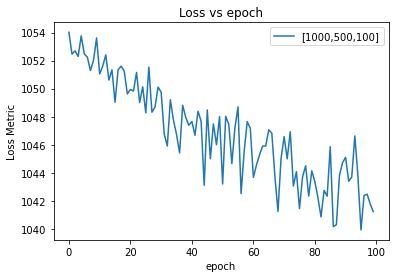

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(NUM_EPOCHS), layer_history.history["loss"], label=ARCH)
plt.title("Loss vs epoch")
plt.xlabel("epoch")
plt.ylabel("Loss Metric");
plt.legend()

## Save the query/event model

These SCaNN indicies can be used just as they were in the bqml-scann example. 

In [24]:
# Export the candidate model.
import tempfile
from tensorflow_io.bigquery import BigQueryClient

candidates = read_dataset_prod(BigQueryClient(), None, batch_size=1024)
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.candidate_model, num_reordering_candidates=1000)

with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")

    # Save the index.
    tf.saved_model.save(scann_index, JOB_DIR,  options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"]))

    # Load it back; can also be done in TensorFlow Serving.
    loaded = tf.saved_model.load(JOB_DIR)

2021-12-21 17:30:44.562364: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://jsw-bucket2/assets
INFO:tensorflow:Assets written to: gs://jsw-bucket2/assets
